In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

sys.path.insert(0, './src')

from data import Dataset
from kernels import HMC_our, HMC_vanilla, Reverse_kernel
from models import Gen_network, Inf_network, Inf_network_simple, Gen_network_simple
from target import NN_bernoulli, GMM_target, NN_Gaussian
from utils import plot_digit_samples, get_samples
from args import get_args

In [2]:
torchType = torch.float32

In [3]:
def set_seeds(rand_seed):
    torch.cuda.manual_seed_all(rand_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)

seed = 1 # 1337 #
set_seeds(seed)

In [4]:
args = get_args()

args.data = "mnist"
args.z_dim = 64
args.data_distrib = GMM_target(args, args.device)

In [5]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

if args.learnable_reverse:
    reverse_kernel = Reverse_kernel(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    
if args.fix_transition_params:
    for p in transitions.parameters():
        transitions.requires_grad_(False)

if args.separate_params:
    params_decoder = list(target.parameters())
    params_inference = list(encoder.parameters()) + list(transitions.parameters()) + list(reverse_params)
    optimizer_inference = torch.optim.Adam(params=params_inference, lr=args.learning_rate_inference)
    optimizer = torch.optim.Adam(params=params_decoder, lr=args.learning_rate)
else:
    params = list(encoder.parameters()) + list(target.parameters()) + list(transitions.parameters()) + list(reverse_params)
    optimizer = torch.optim.Adam(params=params, lr=args.learning_rate)
    
optimizer_vanilla = torch.optim.Adam(params=list(encoder.parameters()) + list(target.parameters()), lr= args.learning_rate_vanilla)

In [6]:
if args.vanilla_vae_epoches > 0:
    batch_size = args.train_batch_size
    args.train_batch_size = 100 # just for Vanilla VAE training
dataset = Dataset(args, device=args.device)

In [7]:
random_code = args.std_normal.sample((64, args.z_dim))

In [8]:
def compute_loss(z_new, p_new, u, p_old, x, sum_log_alpha, sum_log_jac, sum_log_sigma, mu=None, all_directions=None):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=z_new.detach(), mu=mu.detach(), a=all_directions)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
    else:
        log_r = 0 #-args.K * torch_log_2
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma # + sum_log_alpha
    log_p = target.get_logdensity(z=z_new, x=x) + args.std_normal.log_prob(p_new).sum(1)
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full, grad_elbo

In [9]:
def validate_vae(args, encoder, target, transitions, dataset):
    elbo_list = []
    for batch_num, batch_val in enumerate(dataset.next_val_batch()):
        if args.learnable_reverse:
            all_directions = torch.tensor([], device=args.device)
        else:
            all_directions = None
        mu, sigma = encoder(batch_val)
        
        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)

        u = args.std_normal.sample(mu.shape)
        z = mu + sigma * u
        
        p_old = args.std_normal.sample(z.shape)
        cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]
        p = p_old
        
        for k in range(args.K):
            if args.amortize:
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_val,
                                                    p_old=p, k=cond_vectors[k], target_distr=target)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_val,
                                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
            if args.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
        elbo_current, _ = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_val, sum_log_alpha=sum_log_alpha,
                                    sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)
        
        elbo_list.append(elbo_current.cpu().detach().numpy())
    mean_val_elbo = np.mean(elbo_list)
    return mean_val_elbo

  0%|          | 0/1000 [00:00<?, ?it/s]

Current epoch: 1 	 Current ELBO train: -172.6902313232422
Best elbo validation -257.01385
Current elbo validation -257.01385
Saved samples to ./pics/mnist_epoch_0_K_2_N_1_amortize_False.png


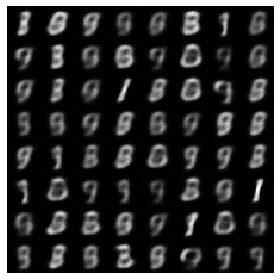

  0%|          | 1/1000 [00:08<2:18:03,  8.29s/it]

Current epoch: 2 	 Current ELBO train: -144.9413604736328
Best elbo validation -236.02654
Current elbo validation -236.02654
Saved samples to ./pics/mnist_epoch_1_K_2_N_1_amortize_False.png


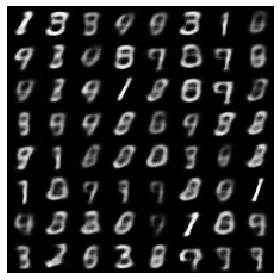

  0%|          | 2/1000 [00:15<2:12:49,  7.99s/it]

Current epoch: 3 	 Current ELBO train: -136.86544799804688
Best elbo validation -222.96269
Current elbo validation -222.96269
Saved samples to ./pics/mnist_epoch_2_K_2_N_1_amortize_False.png


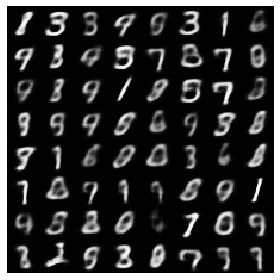

  0%|          | 3/1000 [00:22<2:09:06,  7.77s/it]

Current epoch: 4 	 Current ELBO train: -122.29132080078125
Best elbo validation -213.3825
Current elbo validation -213.3825
Saved samples to ./pics/mnist_epoch_3_K_2_N_1_amortize_False.png


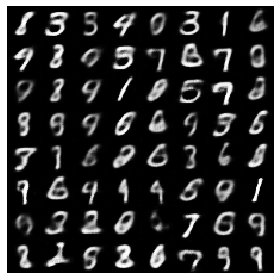

  0%|          | 4/1000 [00:30<2:06:28,  7.62s/it]

Current epoch: 5 	 Current ELBO train: -115.97358703613281
Best elbo validation -207.13951
Current elbo validation -207.13951
Saved samples to ./pics/mnist_epoch_4_K_2_N_1_amortize_False.png


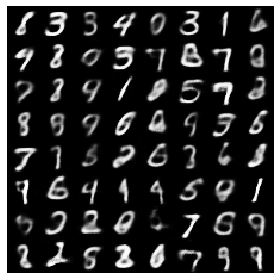

  0%|          | 5/1000 [00:37<2:04:35,  7.51s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.4660000221338123 and for +1: 0.534000025363639
On batch number 1/118 and on k = 2 we have for  0: 0.5120000243186951 and for +1: 0.48800002317875624
On batch number 101/118 and on k = 1 we have for  0: 0.2400000113993883 and for +1: 0.760000036098063
On batch number 101/118 and on k = 2 we have for  0: 0.6000000284984708 and for +1: 0.4000000189989805
Current epoch: 6 	 Current ELBO train: -215.57269287109375
Best elbo validation -207.13951
Current elbo validation -213.56506
Saved samples to ./pics/mnist_epoch_5_K_2_N_1_amortize_False.png


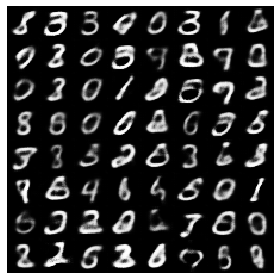

  1%|          | 6/1000 [01:32<6:02:54, 21.91s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.1620000076945871 and for +1: 0.8380000398028642
On batch number 1/118 and on k = 2 we have for  0: 0.6280000298283994 and for +1: 0.3720000176690519
On batch number 101/118 and on k = 1 we have for  0: 0.21800001035444438 and for +1: 0.7820000371430069
On batch number 101/118 and on k = 2 we have for  0: 0.6060000287834555 and for +1: 0.3940000187139958
Current epoch: 7 	 Current ELBO train: -211.89976501464844
Best elbo validation -207.13951
Current elbo validation -210.21529
Saved samples to ./pics/mnist_epoch_6_K_2_N_1_amortize_False.png


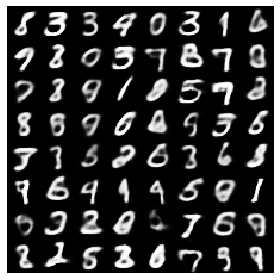

  1%|          | 7/1000 [02:28<8:49:28, 31.99s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.19000000902451575 and for +1: 0.8100000384729356
On batch number 1/118 and on k = 2 we have for  0: 0.6020000285934657 and for +1: 0.3980000189039856
On batch number 101/118 and on k = 1 we have for  0: 0.13600000645965338 and for +1: 0.8640000410377979
On batch number 101/118 and on k = 2 we have for  0: 0.6700000318232924 and for +1: 0.33000001567415893
Current epoch: 8 	 Current ELBO train: -215.72738647460938
Best elbo validation -207.13951
Current elbo validation -215.76318
Saved samples to ./pics/mnist_epoch_7_K_2_N_1_amortize_False.png


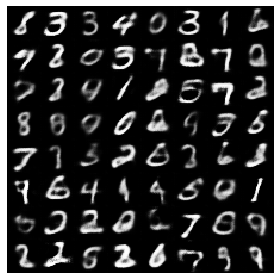

  1%|          | 8/1000 [03:24<10:47:00, 39.13s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.1580000075045973 and for +1: 0.842000039992854
On batch number 1/118 and on k = 2 we have for  0: 0.6020000285934657 and for +1: 0.3980000189039856
On batch number 101/118 and on k = 1 we have for  0: 0.27800001320429146 and for +1: 0.7220000342931598
On batch number 101/118 and on k = 2 we have for  0: 0.3920000186190009 and for +1: 0.6080000288784504
Current epoch: 9 	 Current ELBO train: -209.13673400878906
Best elbo validation -205.87587
Current elbo validation -205.87587
Saved samples to ./pics/mnist_epoch_8_K_2_N_1_amortize_False.png


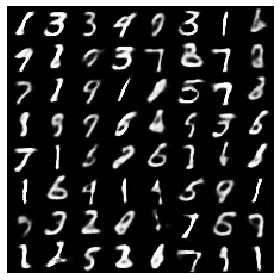

  1%|          | 9/1000 [04:19<12:07:42, 44.06s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.3020000143442303 and for +1: 0.698000033153221
On batch number 1/118 and on k = 2 we have for  0: 0.3820000181440264 and for +1: 0.6180000293534249
On batch number 101/118 and on k = 1 we have for  0: 0.4020000190939754 and for +1: 0.5980000284034759
On batch number 101/118 and on k = 2 we have for  0: 0.34200001624412835 and for +1: 0.658000031253323
Current epoch: 10 	 Current ELBO train: -203.37521362304688
Best elbo validation -203.21925
Current elbo validation -203.21925
Saved samples to ./pics/mnist_epoch_9_K_2_N_1_amortize_False.png


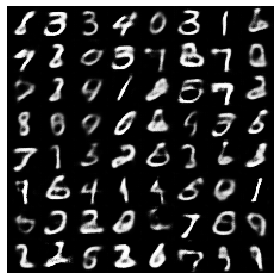

  1%|          | 10/1000 [05:15<13:04:01, 47.52s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.34400001633912325 and for +1: 0.6560000311583281
On batch number 1/118 and on k = 2 we have for  0: 0.370000017574057 and for +1: 0.6300000299233943
On batch number 101/118 and on k = 1 we have for  0: 0.2300000109244138 and for +1: 0.7700000365730375
On batch number 101/118 and on k = 2 we have for  0: 0.4000000189989805 and for +1: 0.6000000284984708
Current epoch: 11 	 Current ELBO train: -204.9782257080078
Best elbo validation -202.12596
Current elbo validation -202.12596
Saved samples to ./pics/mnist_epoch_10_K_2_N_1_amortize_False.png


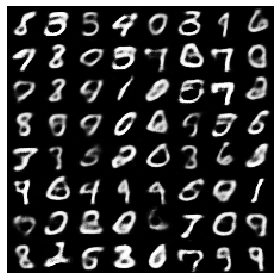

  1%|          | 11/1000 [06:10<13:42:58, 49.93s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.19000000902451575 and for +1: 0.8100000384729356
On batch number 1/118 and on k = 2 we have for  0: 0.5660000268835574 and for +1: 0.43400002061389387
On batch number 101/118 and on k = 1 we have for  0: 0.11800000560469925 and for +1: 0.882000041892752
On batch number 101/118 and on k = 2 we have for  0: 0.6060000287834555 and for +1: 0.3940000187139958
Current epoch: 12 	 Current ELBO train: -203.24122619628906
Best elbo validation -198.95987
Current elbo validation -198.95987
Saved samples to ./pics/mnist_epoch_11_K_2_N_1_amortize_False.png


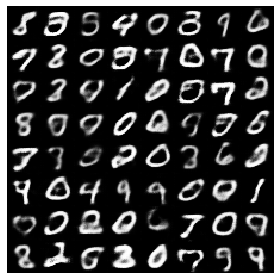

  1%|          | 12/1000 [07:06<14:09:55, 51.62s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.10000000474974513 and for +1: 0.9000000427477062
On batch number 1/118 and on k = 2 we have for  0: 0.6380000303033739 and for +1: 0.3620000171940774
On batch number 101/118 and on k = 1 we have for  0: 0.5380000255536288 and for +1: 0.4620000219438225
On batch number 101/118 and on k = 2 we have for  0: 0.3180000151041895 and for +1: 0.6820000323932618
Current epoch: 13 	 Current ELBO train: -209.89828491210938
Best elbo validation -198.95987
Current elbo validation -202.16591
Saved samples to ./pics/mnist_epoch_12_K_2_N_1_amortize_False.png


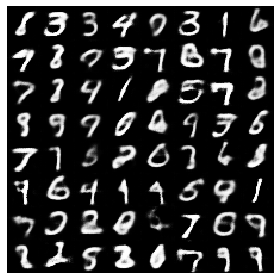

  1%|▏         | 13/1000 [08:02<14:29:40, 52.87s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.43000002042390406 and for +1: 0.5700000270735472
On batch number 1/118 and on k = 2 we have for  0: 0.308000014629215 and for +1: 0.6920000328682363
On batch number 101/118 and on k = 1 we have for  0: 0.2340000111144036 and for +1: 0.7660000363830477
On batch number 101/118 and on k = 2 we have for  0: 0.5440000258386135 and for +1: 0.4560000216588378
Current epoch: 14 	 Current ELBO train: -191.47303771972656
Best elbo validation -191.17587
Current elbo validation -191.17587
Saved samples to ./pics/mnist_epoch_13_K_2_N_1_amortize_False.png


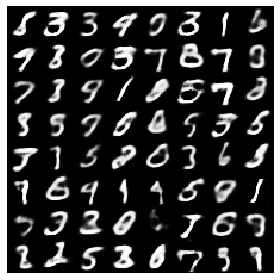

  1%|▏         | 14/1000 [08:57<14:42:14, 53.69s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.27800001320429146 and for +1: 0.7220000342931598
On batch number 1/118 and on k = 2 we have for  0: 0.34400001633912325 and for +1: 0.6560000311583281
On batch number 101/118 and on k = 1 we have for  0: 0.226000010734424 and for +1: 0.7740000367630273
On batch number 101/118 and on k = 2 we have for  0: 0.5460000259336084 and for +1: 0.4540000215638429
Current epoch: 15 	 Current ELBO train: -186.63072204589844
Best elbo validation -187.70416
Current elbo validation -187.70416
Saved samples to ./pics/mnist_epoch_14_K_2_N_1_amortize_False.png


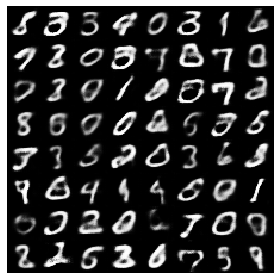

  2%|▏         | 15/1000 [09:53<14:50:48, 54.26s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.26800001272931695 and for +1: 0.7320000347681344
On batch number 1/118 and on k = 2 we have for  0: 0.5580000265035778 and for +1: 0.4420000209938735
On batch number 101/118 and on k = 1 we have for  0: 0.3780000179540366 and for +1: 0.6220000295434147
On batch number 101/118 and on k = 2 we have for  0: 0.27000001282431185 and for +1: 0.7300000346731395
Current epoch: 16 	 Current ELBO train: -205.06202697753906
Best elbo validation -187.70416
Current elbo validation -205.19466
Saved samples to ./pics/mnist_epoch_15_K_2_N_1_amortize_False.png


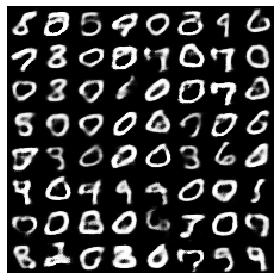

  2%|▏         | 16/1000 [10:48<14:56:09, 54.64s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.27000001282431185 and for +1: 0.7300000346731395
On batch number 1/118 and on k = 2 we have for  0: 0.3100000147242099 and for +1: 0.6900000327732414
On batch number 101/118 and on k = 1 we have for  0: 0.17400000826455653 and for +1: 0.8260000392328948
On batch number 101/118 and on k = 2 we have for  0: 0.4780000227037817 and for +1: 0.5220000247936696
Current epoch: 17 	 Current ELBO train: -203.2064208984375
Best elbo validation -187.70416
Current elbo validation -199.84567
Saved samples to ./pics/mnist_epoch_16_K_2_N_1_amortize_False.png


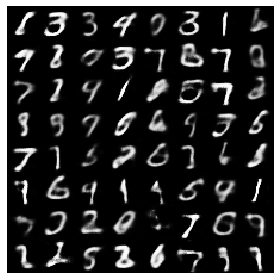

  2%|▏         | 17/1000 [11:44<14:59:36, 54.91s/it]

On batch number 1/118 and on k = 1 we have for  0: 0.18000000854954123 and for +1: 0.8200000389479101
On batch number 1/118 and on k = 2 we have for  0: 0.5660000268835574 and for +1: 0.43400002061389387


In [ ]:
print_info_ = 1
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)

best_elbo = -float("inf")
current_elbo_val = -float("inf")

current_tolerance = 0
# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        target.decoder.train()
        plt.close()        

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        sum_log_sigma = torch.sum(torch.log(sigma), 1)
        if ep < args.vanilla_vae_epoches:
            log_p = target.get_logdensity(z=z, x=batch_train)
            log_m = args.std_normal.log_prob(u).sum(1) - sum_log_sigma
            elbo_full = torch.mean(log_p - log_m)
            (-elbo_full).backward()
            optimizer_vanilla.step()
            optimizer_vanilla.zero_grad()
            if b_num == (args.train_batch_size - 1):
                args.train_batch_size = batch_size
                dataset = Dataset(args, device=args.device)
        else:
            p_old = args.std_normal.sample(z.shape)
            cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]

            sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
            sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
            p = p_old
            if args.learnable_reverse:
                all_directions = torch.tensor([], device=args.device)
            else:
                all_directions = None
            for k in range(args.K):
                # sample alpha - transition probabilities 
                if args.amortize:
#                     pdb.set_trace()
                    z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_train,
                                                        p_old=p, k=cond_vectors[k], target_distr=target)
                else:
                    z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_train,
                                                                        p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
                if ep  % print_info_ == 0 and b_num % (100 * print_info_) == 0:
                    print('On batch number {}/{} and on k = {} we have for  0: {} and for +1: {}'.format(b_num + 1,
                                                                            dataset.train.shape[0] // args['train_batch_size'],
                                                                               k + 1,
                                                        (directions==0.).to(float).mean(),
                                                                        (directions==1.).to(float).mean()))
                    if args.amortize:
                        print('Stepsize {}'.format(np.exp(transitions.gamma.cpu().detach().item())))
                        print('Autoregression coeff {}'.format(torch.sigmoid(transitions.alpha_logit).cpu().detach().item()))
                if args.learnable_reverse:
                    all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
                # Accumulate alphas
                sum_log_alpha = sum_log_alpha + current_log_alphas
                sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian

            elbo_full, grad_elbo = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_train, sum_log_alpha=sum_log_alpha,
                                                sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)
        #     pdb.set_trace()
            (-grad_elbo).backward()
            if args.clip_norm:
                torch.nn.utils.clip_grad_norm_(itertools.chain(*params), args.clip_value)
                
            if args.separate_params: # if we separate params of inference part and generation part
                optimizer_inference.step() # we always perform step for inference part
                if (ep - args.vanilla_vae_epoches) % args.train_only_inference_period > args.train_only_inference_cutoff: # but sometimes for gen
                    optimizer.step()
                optimizer.zero_grad()
                optimizer_inference.zero_grad()
            else:
                optimizer.step()
                optimizer.zero_grad()
                
    ###### validation ######
    target.decoder.eval()
#             pdb.set_trace()
    current_elbo_val = validate_vae(args=args, encoder=encoder, target=target, transitions=transitions, dataset=dataset)
    if (current_elbo_val != current_elbo_val).sum():
        print('NAN appeared!')
        raise ValueError
    if current_elbo_val > best_elbo:
        current_tolerance = 0
        best_elbo = current_elbo_val
        if not os.path.exists('./models/{}/'.format(args.data)):
            os.makedirs('./models/{}/'.format(args.data))
        torch.save(encoder,
            './models/{}/best_encoder_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse))
        torch.save(target.decoder,
            './models/{}/best_decoder_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse))
        torch.save(transitions,
            './models/{}/best_transitions_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse))
        if args.learnable_reverse:
            torch.save(reverse_kernel,
            './models/{}/best_reverse_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse))

    else:
        current_tolerance += 1
        if current_tolerance >= args.early_stopping_tolerance:
            print("Early stopping on epoch {} (effectively trained for {} epoches)".format(ep,
                                              ep - args.early_stopping_tolerance))
            break
                
    if ep % print_info_ == 0:
        target.decoder.eval()
        print('Current epoch:', (ep + 1), '\t', 'Current ELBO train:', elbo_full.detach().mean().item())
        print('Best elbo validation', best_elbo)
        print('Current elbo validation', current_elbo_val)
        plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)

In [ ]:
print(best_elbo)

In [ ]:
elbo_full.mean()

In [ ]:
print(args.learnable_reverse)

## Vanilla VAE

In [ ]:
dataset = Dataset(args, device=args.device)

In [ ]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

params = [encoder.parameters(), target.parameters()]
optimizer = torch.optim.Adam(params=itertools.chain(*params), lr=args.learning_rate)

In [ ]:
print_info_ = 10

# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        plt.close()
        optimizer.zero_grad()

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        
        mu_dec, sigma_dec = target.decoder(z)
        if args.data == 'toy_data':
            log_numenator = torch.distributions.Normal(loc=mu_dec, scale=sigma_dec).log_prob(batch_train).sum(1) + args.std_normal.log_prob(z).sum(1)
        else:
            log_numenator = torch.distributions.Bernoulli(logits=mu_dec).log_prob(batch_train).sum([1, 2, 3]) + args.std_normal.log_prob(z).sum(1)
        log_denumenator = -torch.sum(torch.log(sigma), 1) + args.std_normal.log_prob(u).sum(1)
        elbo = torch.mean(log_numenator - log_denumenator)
        (-elbo).backward()

        optimizer.step()
        optimizer.zero_grad()
    if ep % print_info_ == 0:
        if args.data == 'toy_data':
            print('Current epoch:', (ep + 1), '\t', 'Current ELBO:', elbo.detach().mean().item())
            print('Mean abs mu0:', torch.mean(torch.abs(mu_dec[:, 0])).cpu().detach().numpy())
            print('Mean sigma', torch.mean(sigma).cpu().detach().numpy())
            print('Max sigma', torch.max(sigma).cpu().detach().numpy())
            print('Min sigma', torch.min(sigma).cpu().detach().numpy())
            plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1], label='Data')
            plt.scatter(mu_dec.cpu().detach().numpy()[:, 0], mu_dec.cpu().detach().numpy()[:, 1], label='Reconstructed')
            plt.legend()
            plt.show()
        else:
            plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)

In [ ]:
target.decoder.linear1.bias